# init
@author: Alexandre Pereira Santos <br>
alexandre.santos(at)lmu.de

## Tasks
- get OpenStreetMap data using the osmnx functionalities in the Overpass API
- clip it to an AOI

## Prerequisites
- have osmnx and geopandas installed
- have an AOI saved as a vector (shapefile or geopackage)

In [11]:
import osmnx as ox
import geopandas as gpd
from pathlib import Path
import pandas as pd

# imports

In [4]:
#import the AOI
AOI_path = Path(r'D:\\Dropbox\\x\\PostDoc\\23 10 LMU\\13 exp_cases\\24 01 Urban SSP MAN MUM JAK\\GIS_temp\\')
AOI_file = 'JAK_LIM_BoundingBox_AOI_A.shp'
AOI_gdf = gpd.read_file(AOI_path / AOI_file)

#bounds provides minx, miny, maxx, maxy
aoi_coords = AOI_gdf.to_crs(epsg='4326').envelope
bbox_df = gpd.GeoDataFrame(geometry=aoi_coords)
print('N',aoi_coords.bounds.values[0][3],'S',aoi_coords.bounds.values[0][1],'W',aoi_coords.bounds.values[0][0],'E',aoi_coords.bounds.values[0][2])

N -5.924775462093303 S -6.78749996341632 W 106.25833288099368 E 107.23811669088865


<Axes: >

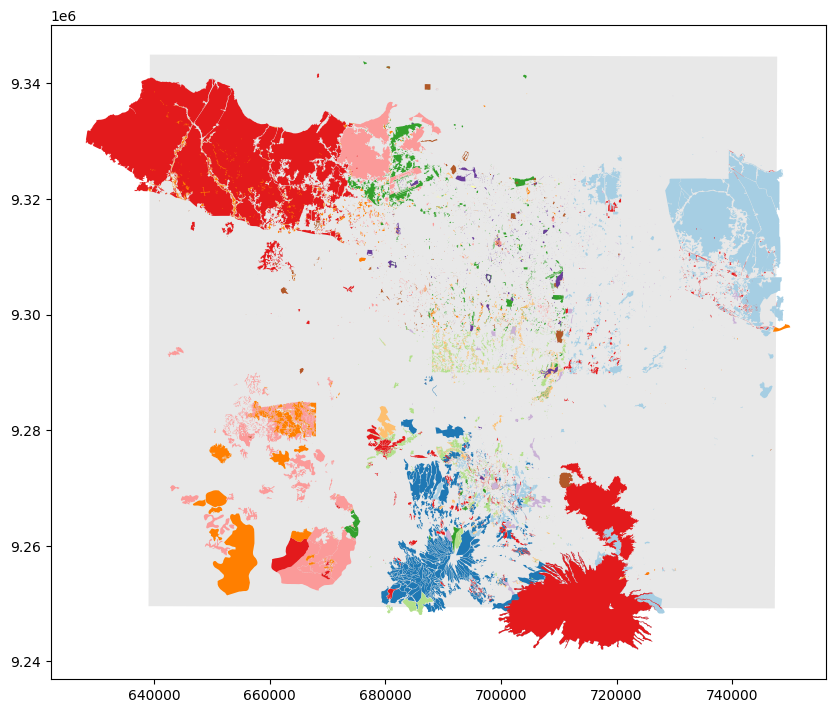

In [23]:
#get green areas  features from OSM
dict_tags = {
    'landuse': {'landuse': ['forest', 'meadow', 'grass', 'allotments', 'recreation_ground', 'village_green', 'cemetery',
                'orchard', 'vineyard', 'plant_nursery', 'farmland', 'farmyard', 'farm', 'grassland', 'greenfield']},
    'natural': {'natural': ['wood', 'tree', 'scrub', 'heath', 'moor', 'grassland', 'fell', 'bare_rock', 'scree', 'shingle']},
    'leisure': {'leisure': ['park', 'garden', 'golf_course', 'playground', 'sports_centre', 'stadium', 'pitch', 'recreation_ground', 
                'common', 'village_green', 'dog_park', 'nature_reserve', 'wildlife_hide', 'bird_hide']},
    'tourism':{'tourism':['camp_site']},
    'boundary': {'boundary': ['national_park', 'protected_area']}
    }
# List key-value pairs for tags
green_areas_1 = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                                      south=aoi_coords.bounds.values[0][1],
                                      west=aoi_coords.bounds.values[0][0],
                                      east=aoi_coords.bounds.values[0][2],
                                      tags=dict_tags['landuse'])
green_areas_2 = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                                      south=aoi_coords.bounds.values[0][1],
                                      west=aoi_coords.bounds.values[0][0],
                                      east=aoi_coords.bounds.values[0][2],
                                      tags=dict_tags['natural'])
green_areas_3 = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                                      south=aoi_coords.bounds.values[0][1],
                                      west=aoi_coords.bounds.values[0][0],
                                      east=aoi_coords.bounds.values[0][2],
                                      tags=dict_tags['leisure'])
green_areas_4 = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                                      south=aoi_coords.bounds.values[0][1],
                                      west=aoi_coords.bounds.values[0][0],
                                      east=aoi_coords.bounds.values[0][2],
                                      tags=dict_tags['tourism'])
green_areas_5 = ox.features_from_bbox(north=aoi_coords.bounds.values[0][3],
                                      south=aoi_coords.bounds.values[0][1],
                                      west=aoi_coords.bounds.values[0][0],
                                      east=aoi_coords.bounds.values[0][2],
                                      tags=dict_tags['boundary'])
    
col_list = ['osmid','geometry','element_type', 'name'] #OSM has hundreds of cols, we just want a few. 
green_areas_1.reset_index(inplace=True)
green_areas_2.reset_index(inplace=True)
green_areas_3.reset_index(inplace=True)
green_areas_4.reset_index(inplace=True)
green_areas_5.reset_index(inplace=True)

#filtering out the wrong geometries (Polyline or Point) 
green_areas_1 = green_areas_1.loc[(green_areas_1.geometry.type=='Polygon'), col_list] #&(water_linear.element_type == 'way') , col_list
green_areas_2 = green_areas_2.loc[(green_areas_2.geometry.type=='Polygon'), col_list]
green_areas_3 = green_areas_3.loc[(green_areas_3.geometry.type=='Polygon'), col_list]
green_areas_4 = green_areas_4.loc[(green_areas_4.geometry.type=='Polygon'), col_list]
green_areas_5 = green_areas_5.loc[(green_areas_5.geometry.type=='Polygon'), col_list]

#convert the CRS of roads to the same as AOI
green_areas_1.to_crs(AOI_gdf.crs,inplace=True)
green_areas_2.to_crs(AOI_gdf.crs,inplace=True)
green_areas_3.to_crs(AOI_gdf.crs,inplace=True)
green_areas_4.to_crs(AOI_gdf.crs,inplace=True)
green_areas_5.to_crs(AOI_gdf.crs,inplace=True)

#merge the dataframes
green_areas = pd.concat([green_areas_1,green_areas_2,green_areas_3,green_areas_4,green_areas_5], ignore_index=True)

#plot them
green_areas.plot(ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2) 



<Axes: >

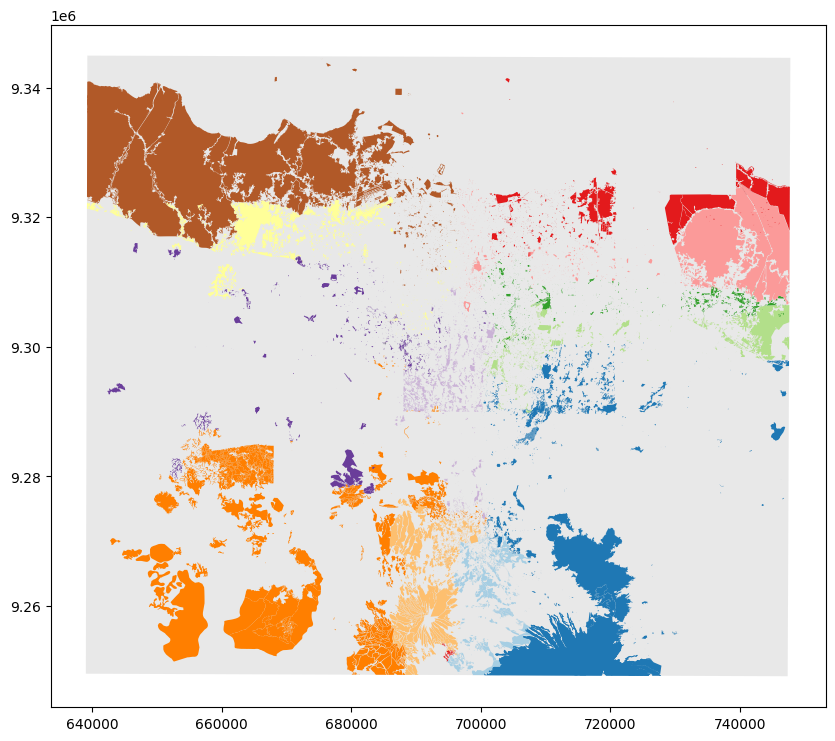

In [24]:
#clip using geopandas, the mask is the AOI we imported above
green_areas_clipped = gpd.clip(green_areas, mask=AOI_gdf, keep_geom_type=True)
green_areas_clipped.plot(ax=AOI_gdf.plot(figsize=(10, 10),  alpha=0.5, color='lightgray'),cmap='Paired', linewidth=1, zorder=2) #'waterway',

# export

In [25]:
#export roads  to a shapefile
green_areas_clipped.to_file(AOI_path / 'JAK_ENV_green_areas_OSM_2024_A.shp')

C:\Users\ra42zek\AppData\Local\Temp\ipykernel_27480\2539048397.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  green_areas_clipped.to_file(AOI_path / 'JAK_ENV_green_areas_OSM_2024_A.shp')
